In [68]:
import pandas as pd
import geopandas as gpd
from sklearn.metrics import precision_score, recall_score,mean_squared_error,r2_score,confusion_matrix
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
run = "test"
description = "test"
agg = "segments"

In [56]:
#pred = pd.read_csv(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/classification_results.csv")

In [57]:
#pred.groupby('type_pred').size()

In [71]:
gt = gpd.read_file("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/Berlin/Radverkehr_priorisierungskonzept/priorisierungskonzept_validation.gpkg", 
                   dtype={"id": int})
gt = gt[["id", "gid", "ELEM_NR", "checked", "type_ground_truth", "quality_ground_truth"]]

In [73]:
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred.shp")
columns = ["ID", "TYPE_PRED", "AVG_QUALIT", "AVG_IMG_CO", "SUM_IMG_CO"] #"AVG_CLASS_", "WAY_LENGTH",  
if agg == "segments":
    columns += ["GROUP_NUM"]
pred = pred[columns]
pred.rename(columns={"ID":"id", "TYPE_PRED": "type_pred", "AVG_QUALIT": "avg_quality_pred"}, inplace=True) #"AVG_CLASS_": "avg_class_prob",
pred["uid"] = pred.id.astype(str) +"_" + pred.GROUP_NUM.astype(str)

In [74]:
df = gt.set_index("id").join(pred.set_index("id"))
df = df[df.type_pred.notna()]
df = df[df.type_ground_truth.notna()]
acc_type = (df.type_pred == df.type_ground_truth).sum() / len(df)
acc_type

0.90625

In [65]:
#df[df.type_pred == df.type_ground_truth].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

In [75]:
# all asphalt benchmark
(df.type_ground_truth == "asphalt").sum() / len(df)

0.751953125

In [67]:
# all asphalt benchmark
#df[df.type_ground_truth == "asphalt"].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

#### Confusion matrix surface types

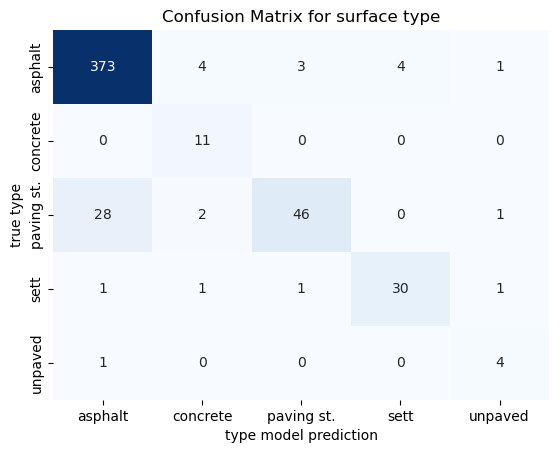

In [76]:
cm = confusion_matrix(df.type_ground_truth, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
#plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

In [79]:
# mismatched streets
m = df[df.type_pred != df.type_ground_truth]
# get geometries
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred.shp")
pred["uid"] = pred.ID.astype(str) +"_" + pred.GROUP_NUM.astype(str)
misclassified = pred[pred["uid"].isin(m.uid)]

In [ ]:
misclassified.to_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/misclassified_{agg}.gpkg", driver="GPKG")

In [80]:
pred[~pred.uid.isin(misclassified.uid)].CONF_SCORE.describe()

count    772.000000
mean       0.843626
std        0.154914
min        0.306250
25%        0.773644
50%        0.892893
75%        0.962574
max        1.000000
Name: CONF_SCORE, dtype: float64

In [81]:
misclassified.CONF_SCORE.describe()

count    48.000000
mean      0.646462
std       0.201647
min       0.303333
25%       0.460253
50%       0.623575
75%       0.814917
max       1.000000
Name: CONF_SCORE, dtype: float64

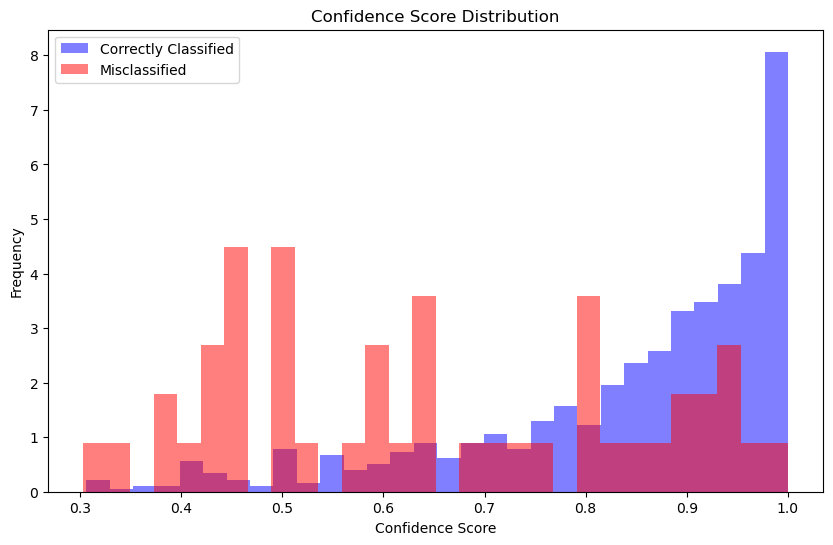

In [82]:
# Plot overlapping histograms
plt.figure(figsize=(10, 6))

# Histogram for correctly classified predictions
plt.hist(pred[~pred.ID.isin(misclassified.ID)]['CONF_SCORE'], bins=30, color='blue', alpha=0.5, label='Correctly Classified', density=True)

# Histogram for misclassified predictions
plt.hist(misclassified['CONF_SCORE'], bins=30, color='red', alpha=0.5, label='Misclassified', density=True)

# Add titles and labels
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

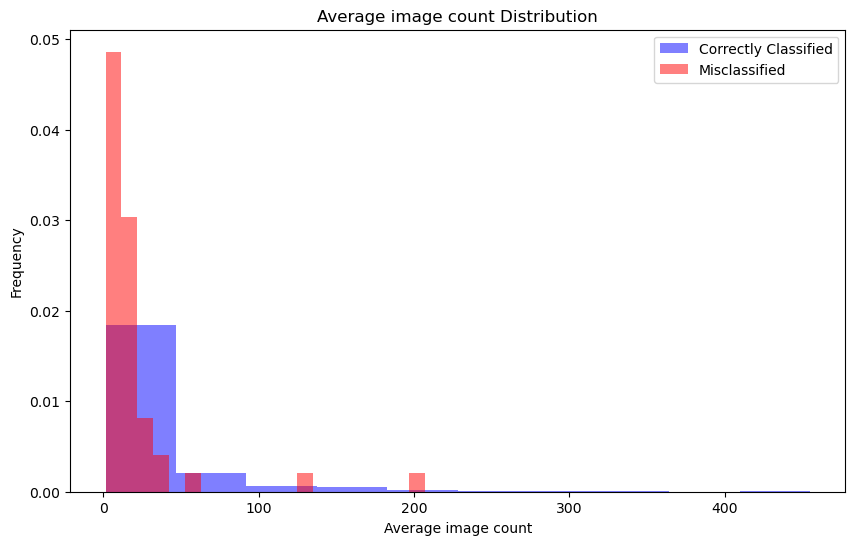

In [93]:
# Plot overlapping histograms
plt.figure(figsize=(10, 6))

# Histogram for correctly classified predictions
plt.hist(pred[~pred.ID.isin(misclassified.ID)]['AVG_IMG_CO'], bins=10, color='blue', alpha=0.5, label='Correctly Classified', density=True)

# Histogram for misclassified predictions
plt.hist(misclassified['AVG_IMG_CO'], bins=20, color='red', alpha=0.5, label='Misclassified', density=True)

# Add titles and labels
plt.title('Average image count Distribution')
plt.xlabel('Average image count')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [84]:
pred[~pred.ID.isin(misclassified.ID)].AVG_IMG_CO.describe()

count    772.000000
mean      32.360847
std       45.303754
min        1.333333
25%        8.968750
50%       18.858333
75%       34.667500
max      455.000000
Name: AVG_IMG_CO, dtype: float64

In [85]:
misclassified.AVG_IMG_CO.describe()

count     48.000000
mean      19.522501
std       33.974035
min        1.333333
25%        4.916667
50%       11.821429
75%       18.232143
max      207.000000
Name: AVG_IMG_CO, dtype: float64

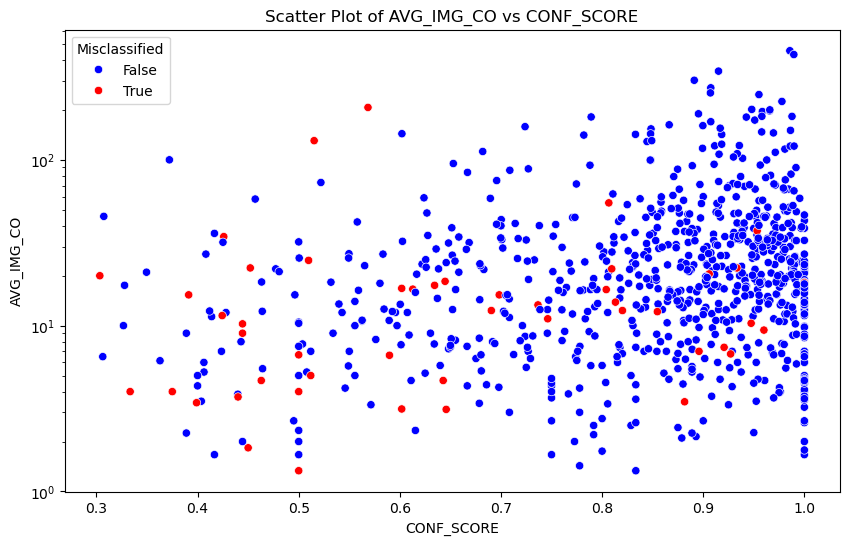

In [86]:
# Create a new column to indicate misclassification
pred['is_misclassified'] = pred.ID.isin(misclassified.ID)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pred, y='AVG_IMG_CO', x='CONF_SCORE', hue='is_misclassified', palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot of AVG_IMG_CO vs CONF_SCORE')
plt.ylabel('AVG_IMG_CO')
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('CONF_SCORE')
plt.legend(title='Misclassified')
plt.show()

In [89]:
pred.AVG_IMG_CO[~pred.AVG_IMG_CO.isna()]

0       4.444444
1      17.000000
2      11.000000
3      23.500000
4      13.000000
         ...    
873    57.000000
874    18.000000
875    38.916667
876     8.625000
877     3.625000
Name: AVG_IMG_CO, Length: 820, dtype: float64

In [90]:
import numpy as np
np.corrcoef(pred.AVG_IMG_CO[~pred.AVG_IMG_CO.isna()], pred.CONF_SCORE[~pred.AVG_IMG_CO.isna()])

array([[1.        , 0.15522867],
       [0.15522867, 1.        ]])

apparently, number of images and confidence score are two predictors if an image is misclassified, however, they are not correlated.

### Quality

In [91]:
df["quality_ground_truth_float"] = df.quality_ground_truth.map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [92]:
def quality_to_class(quality_float):
    if quality_float < 1.5:
        return "excellent"
    elif quality_float < 2.5:
        return "good"
    elif quality_float < 3.5:
        return "intermediate"
    elif quality_float < 4.5:
        return "bad"
    elif quality_float < 5.5:
        return "very_bad"
    else:
        return None
    
df["quality_pred"] = df.avg_quality_pred.apply(quality_to_class)

In [95]:
df.loc[df.avg_quality_pred > 6, "avg_quality_pred"] = None

In [96]:
df["deviation"] = df.quality_ground_truth_float - df.avg_quality_pred
df.deviation.describe()

count    510.000000
mean       0.016675
std        0.588305
min       -2.664332
25%       -0.415644
50%        0.063782
75%        0.358768
max        1.895019
Name: deviation, dtype: float64

In [97]:
df_quality = df[df.quality_ground_truth_float.notna() & df.avg_quality_pred.notna()] 
mse = mean_squared_error(df_quality.quality_ground_truth_float, df_quality.avg_quality_pred)
mse

0.345701804885676

In [98]:
df.deviation.describe()

count    510.000000
mean       0.016675
std        0.588305
min       -2.664332
25%       -0.415644
50%        0.063782
75%        0.358768
max        1.895019
Name: deviation, dtype: float64

<Axes: >

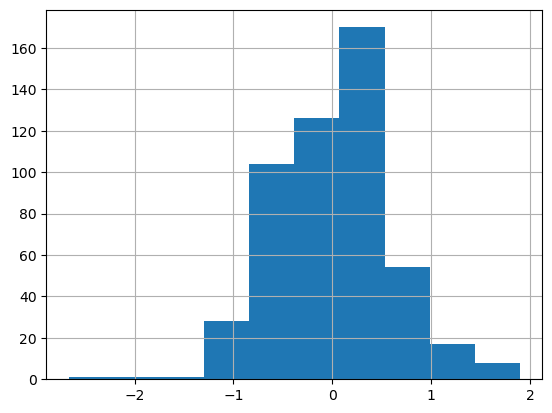

In [99]:
df.deviation.hist()

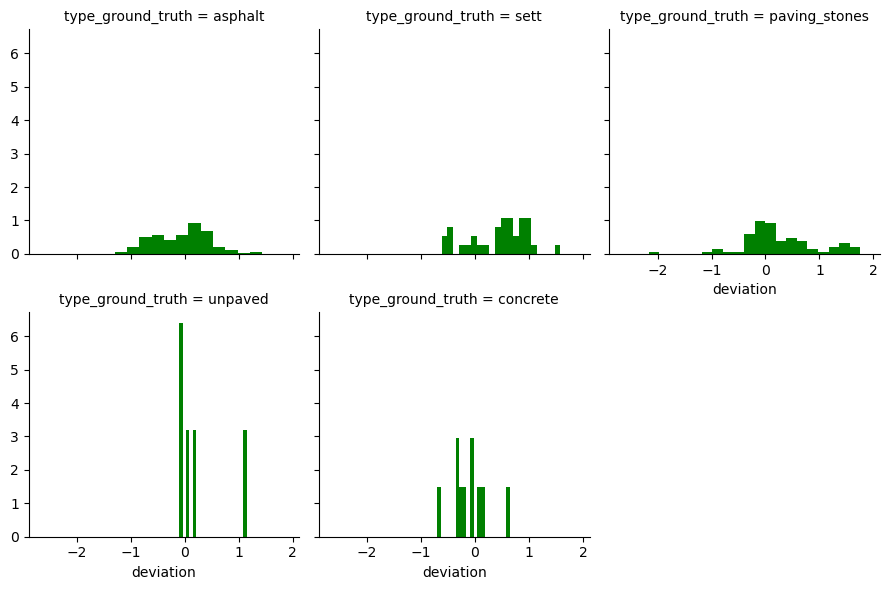

In [100]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="type_ground_truth", col_wrap=3)

# Map histogram for a deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

# positive deviation means that the quality is overestimated

In [101]:
results_df = pd.DataFrame({
    'run':run,
    'description': description,
    'type_accuracy': [round(acc_type, 3)],
    'quality_mean_squared_error': [round(mse, 3)]
})

# Append results to CSV
csv_file_path = '/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/aggregation_alg_results.csv'
results_df.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)
